In [23]:
import numpy as np
import sys
import math
from collections import Counter
from sklearn import datasets
from sklearn import model_selection
import matplotlib.pyplot as plt
import pydotplus 

from IPython.display import Image
%matplotlib inline

### Построение решающего дерева 

In [24]:
class DecisionTree:
    def __init__(self, classify=True, max_depth=sys.maxint):
        self.max_depth = max_depth
        self.r = None
        self.l = None
        self.col = None
        self.value = None
        self.classify = classify
        
    def divideSet(self, data, target, col, value):
        data_r = []
        data_l = []
        target_l = []
        target_r = []
        for idx, data_i in enumerate(data):
#             print col
            if data_i[col] <= value:
                data_l.append(data_i)
                target_l.append(target[idx])
            else:
                data_r.append(data_i)
                target_r.append(target[idx])
        return np.array(data_l), np.array(target_l), np.array(data_r), np.array(target_r)
    
    def gini_score(self, labels):
        cnt = Counter()
        for word in labels:
            cnt[word] += 1
#         print cnt
        p = 1. * np.array(cnt.values()) / labels.size
#         print p
        logp = np.array([math.log(p_i) for p_i in p])
        return - (p * logp).sum()
    
    def gini_break_score(self, labels, l_labels, r_labels):
        return self.gini_score(labels)- \
    1. * l_labels.size / labels.size * self.gini_score(l_labels) - \
    1.* r_labels.size / labels.size * self.gini_score(r_labels)
    
    def calc_node_value(self, data_points):
        if (self.classify):
            counts = np.bincount(data)
            return np.argmax(counts)
        else:
            return data_points.mean()
        
    def mse_score(self, labels):
        labels = np.array(labels)
        return ((labels - labels.mean())**2).sum() / labels.size
        
    def mse_break_score(self,labels, l_labels,r_labels):
        return self.mse_score(labels) - \
            1. * l_labels.size / labels.size * self.mse_score(l_labels) - \
            1. * r_labels.size / labels.size * self.mse_score(r_labels)
               
               
    def buildTree(self, data, target, depth):
#         print data.shape[0]
        self.label = self.calc_node_value(target)
#         print self.label
        best_score = -sys.maxint
        if depth == self.max_depth or data.shape[0] <= 1:
            return
#         print data.shape
        for col, column in enumerate(data.T):
            for value in np.percentile(column, np.linspace(10, 90, 9)):
                l_test_data, l_test_labels, r_test_data, r_test_labels = self.divideSet(data, target, col, value)
                if self.classify:
                    cur_score = self.gini_break_score(target, l_test_labels, r_test_labels)
                else:
                    cur_score = self.mse_break_score(target, l_test_labels,r_test_labels)
#                     print scorе
                if cur_score > best_score:
                    best_score = cur_score
                    self.col = col
                    self.value = value
#         print cur_score
        l_data, l_target, r_data, r_target = self.divideSet(data, target, self.col, self.value)
#         print l_data.size, r_data.size, data.size
        self.l = DecisionTree(self.classify, self.max_depth)
        self.r = DecisionTree(self.classify, self.max_depth)
        self.r.buildTree(r_data, r_target, depth + 1)
        self.l.buildTree(l_data, l_target, depth + 1)                  
                
    def train(self, test_data, test_target):
        self.buildTree(test_data, test_target, 0)     
            
    def predict(self, test_row):
#         print self.label
        if self.l == None:
            return self.label
#         print test_row, self.col
#         print test_row[self.col], self.value
        if test_row[self.col] < self.value:
            return self.l.predict(test_row)
        else:
            return self.r.predict(test_row)
        

параметр classify отвечает за то, будет ли дерево классифицирующим или регрессионным

In [25]:
boston = datasets.load_boston()

In [26]:
tree = DecisionTree(classify=False, max_depth=5)

In [27]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(boston.data, boston.target, test_size=0.25, random_state=42)

In [28]:
tree.train(X_train, y_train)

/home/valeriyasin/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/valeriyasin/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/valeriyasin/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:47: RuntimeWarning: invalid value encountered in double_scalars


посмотрим качество 

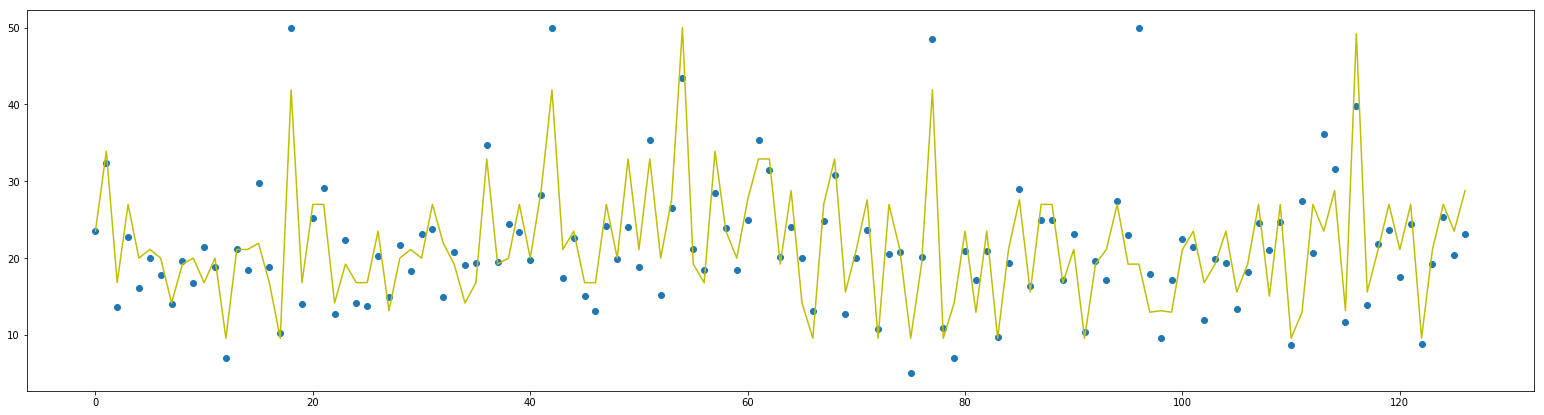

In [29]:
f = plt.figure(figsize=(27,7))
plt.scatter(np.arange(y_test.size), y_test)
plt.plot(np.arange(y_test.size), [tree.predict(X_test_i) for X_test_i in X_test], c="y")
# plt.plot(X_test, [tree.predict(X_test_i) for X_test_i in X_test])

In [30]:
from sklearn.metrics import mean_squared_error

In [33]:
mean_squared_error(y_test, [tree.predict(X_test_i) for X_test_i in X_test])

21.985112686855125

### 2. Применение решающего дерева

функция для перевода категориальных признаков в вещественные

In [42]:
def process_attribute(data, j, attr, attr_set):
#     print attr
    if attr in attr_set:
        return attr_set[attr]
    n = len(data[0])
    res = 0.
    try:
        res = int(attr)
#         print res
    except:
        res = len(filter(lambda x : x[j] == attr and x[n - 1] == '1', data)) * 1. / \
        len(filter(lambda x : x[j] == attr, data))
        attr_set[attr] = res
#     print attr, res
    return res

In [44]:
raw_data = []
with open("data_q.txt", "r") as f:
    for line in f.read().splitlines():
        raw_data.append(line.split())
        
raw_data = np.array(raw_data)
data = []
# print data.shape   
attr_set = {}        
for row in raw_data:
    data_row = []
    for idx, x in enumerate(row):
        data_x = process_attribute(raw_data, idx, x, attr_set)
        data_row.append(data_x)
    data.append(data_row)
    
data = np.array(data)
target = map(lambda x : int(x), data[: , data.shape[1] - 1])
data = np.delete(data, data.shape[1] - 1, axis=1)

In [46]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [47]:
dtree =  DecisionTreeClassifier(max_depth=3)

In [48]:
dtree.fit(data, target)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [49]:
dot_data = tree.export_graphviz(dtree, out_file="small_tree.out")


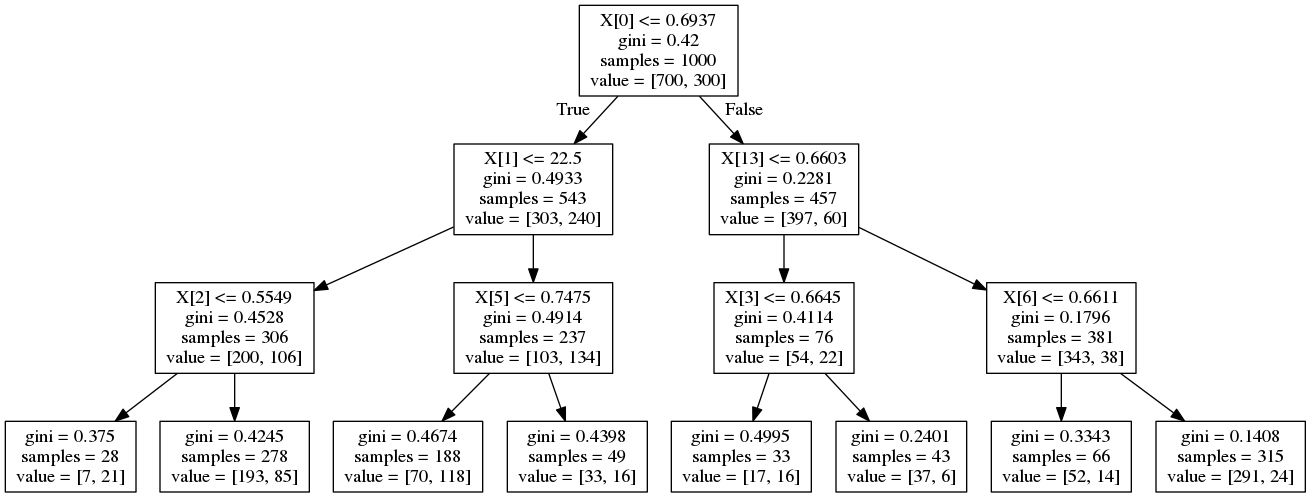

In [50]:
graph = pydotplus.graphviz.graph_from_dot_file("small_tree.out")  
Image(graph.create_png())

In [51]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

Найдем наилучшую глубину по кросс-валидации

In [66]:
cross_val = []
test = []
for max_depth in range(1, 11):
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.25, random_state=42)
    dtree = DecisionTreeClassifier(max_depth=max_depth).fit(X_train, y_train)
    y_pred = dtree.predict(X_test, y_test)
    test_score = accuracy_score(y_test, y_pred)
    test.append(test_score)
    cross_val.append(cross_val_score(DecisionTreeClassifier(max_depth=max_depth), data, target).mean())

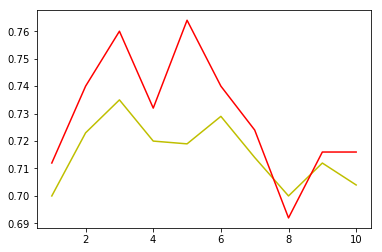

In [67]:
plt.plot(np.linspace(1, 10, 10), cross_val, c="y")
plt.plot(np.linspace(1, 10, 10), test, c="r")

In [68]:
print np.argmax(cross_val) + 1
print np.argmax(test) + 1

3
5


С numeric признаками:

In [85]:
raw_data = []
with open("data.txt", "r") as f:
    for line in f.read().splitlines():
#         print line
        raw_data.append(line.split())
        
raw_data = np.array(raw_data)
data = []
# print data.shape   
attr_set = {}        
for row in raw_data:
    data_row = []
    for idx, x in enumerate(row):
        data_x = int(x)
        data_row.append(data_x)
    data.append(data_row)
    
data = np.array(data)
target = data[: , data.shape[1] - 1]
data = np.delete(data, data.shape[1] - 1, axis=1)

In [86]:
dtree =  DecisionTreeClassifier(max_depth=3)

In [87]:
dtree.fit(data, target)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [88]:
dot_data = tree.export_graphviz(dtree, out_file="small_tree.out")

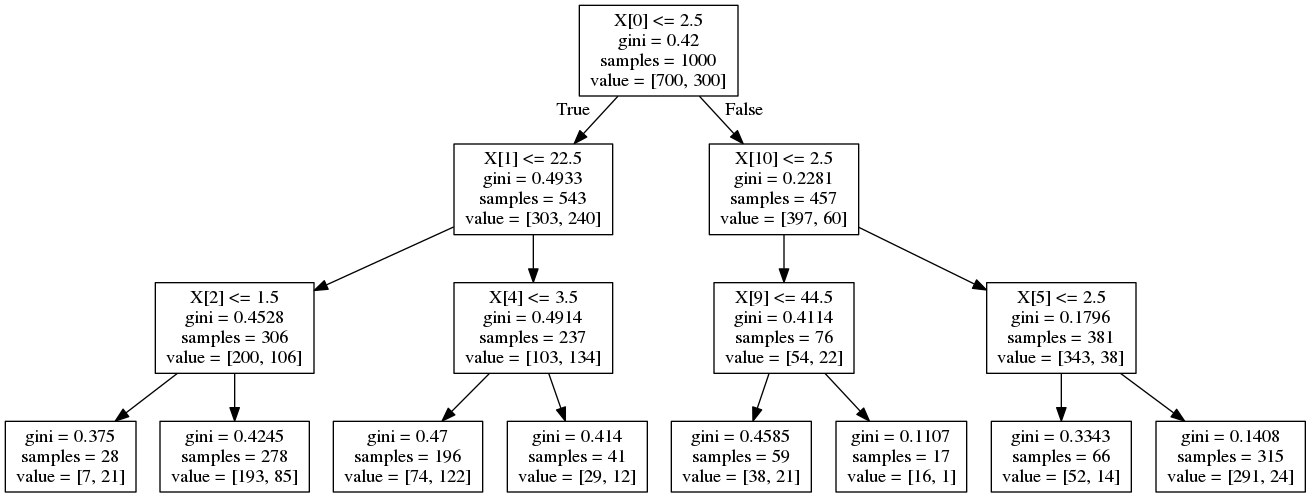

In [89]:
graph = pydotplus.graphviz.graph_from_dot_file("small_tree.out")  
Image(graph.create_png())

In [102]:
cross_val = []
test = []
for max_depth in range(1, 11):
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.25, random_state=42)
    dtree = DecisionTreeClassifier(max_depth=max_depth).fit(X_train, y_train)
    y_pred = dtree.predict(X_test, y_test)
    test_score = accuracy_score(y_test, y_pred)
    test.append(test_score)
    cross_val.append(cross_val_score(DecisionTreeClassifier(max_depth=max_depth), data, target).mean())

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

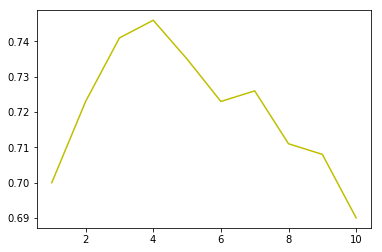

In [96]:
plt.plot(np.linspace(1, 10, 10), cross_val, c="y")
# plt.plot(np.linspace(1, 10, 10), test, c="r")

In [97]:
print np.argmax(cross_val) + 1
print np.argmax(test) + 1

4


ValueError: attempt to get argmax of an empty sequence

Видно, что при нашем преобразовании признаков score больше!